## Código para realizar la transformación de la imagen de la cancha

In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from skimage import color

In [2]:
#Utils
def bgr2rgb(bgr_img):
    b,g,r = cv2.split(bgr_img)       
    rgb_img = cv2.merge([r,g,b])     
    return rgb_img

def find_nearest_line(lines, lineAprox):
    n_lines =len(lines)
    dist=np.zeros(n_lines)
    
    for i in range(n_lines):
        #Calculate similarity 
        dist[i] = np.linalg.norm(lineAprox-lines[i])

    sorted_index=np.argsort(dist)
    return lines[sorted_index[0]]

def transform_point(point, transformation_matrix):
    point = np.append(np.array(point),1)
    num1 = np.dot(transformation_matrix[0,:],point)
    num2 = np.dot(transformation_matrix[1,:],point)
    den = np.dot(transformation_matrix[2,:],point)
    return np.array([num1/den,num2/den])

def line_intersection(line1, line2):
    rho1, theta1 = line1[0]
    rho2, theta2 = line2[0]
    A = np.array([[np.cos(theta1),np.sin(theta1)],[np.cos(theta2),np.sin(theta2)]])
    B = np.array([[rho1],[rho2]])
    A_inv = np.linalg.inv(A)
    out = np.matmul(A_inv,B)
    return out[:,0]

In [13]:

transformation_matrix

array([[ 1.47365839e+00,  3.19942284e+00, -1.03727174e+03],
       [-6.49811962e-03,  4.39010603e+00, -1.73112034e+03],
       [-8.28969962e-05,  8.88152695e-03,  1.00000000e+00]])

### Leer imagen

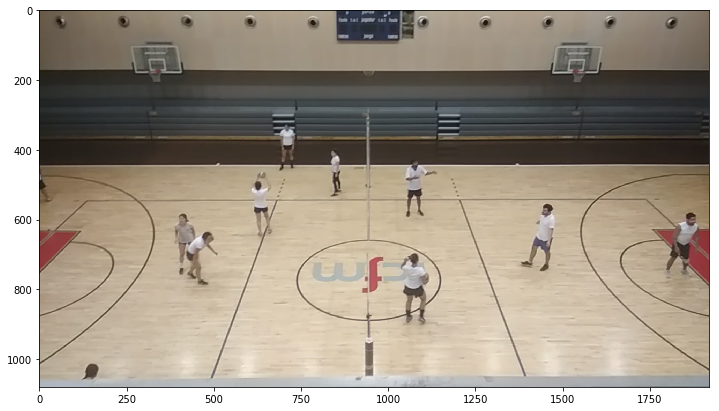

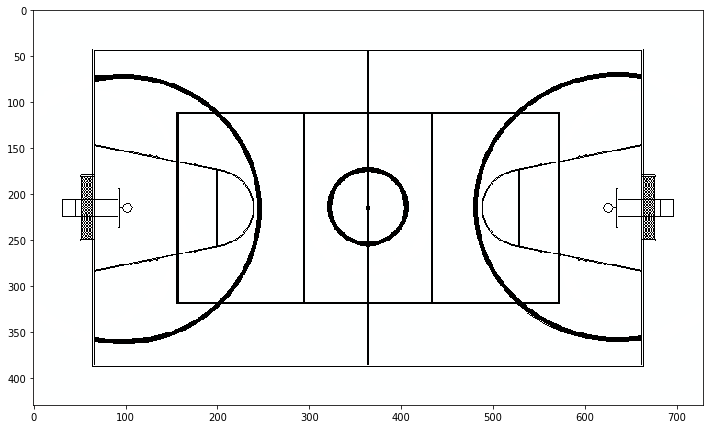

In [3]:
#Load and plot image

#Image path
image_path = "imagenes_videos/imagen_cancha.png"
dibujo_path = "imagenes_videos/dibujo_cancha.png"

#Read image
img=cv2.imread(image_path,1)
img_dibujo = cv2.imread(dibujo_path,1)

#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img))

#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img_dibujo))

## Explorar dibujo con opencv

In [4]:
import math

def calculo_elevacion_velocidad(punto_malla, punto_persona, punto_omni=(0, 1)):
    #Ajuste de parabola
    coordenadas_x = [punto_omni[0], punto_malla[0], punto_persona[0]]
    coordenadas_y = [punto_omni[1], punto_malla[1], punto_persona[1]]
    coeficientes_parabola = np.polyfit(coordenadas_x, coordenadas_y, 2)
    
    #Calculo de elevacion (con pendiente de parabola evaluada en el x del omni)
    elevacion_pendiente = 2*coeficientes_parabola[0]*punto_omni[0]+coeficientes_parabola[1]
    elevacion_angulo = math.atan2(elevacion_pendiente,1)
    
    #Calculo de velocidad
    gravedad=-9.81
    v_0 = np.sqrt((0.5*gravedad*punto_persona[0]**2) / 
                 (np.cos(elevacion_angulo)**2 * ((punto_persona[1]-punto_omni[1])-
                                                  np.tan(elevacion_angulo)*punto_persona[0])))
    return elevacion_angulo, v_0
    

def calculo_orientacion_elevacion_velocidad(posicion_persona, altura_sobre_malla = 50, posicion_omni = (582, 216)):
    x_malla = 364
    pixeles_a_metros_x = 18/(572-158)
    pixeles_a_metros_y = 9/(320-113)
    
    # Distancias en x
    a = (posicion_omni[0] - x_malla)*pixeles_a_metros_x
    b = (x_malla - posicion_persona[0])*pixeles_a_metros_x
    # Distancia en y
    c = (posicion_omni[1] - posicion_persona[1])*pixeles_a_metros_y
    
    #Si la persona esta a la derecha de la malla
    if posicion_persona[0] > x_malla:
        print('La persona debe estar al otro lado de la cancha') 
        orientacion = math.atan2(c, (a+b))
        cos_orientacion = np.cos(orientacion)
        d_mas_e = (a+b) / cos_orientacion
        d = d_mas_e/2
        e = d_mas_e/2
        punto_malla = (d, 2.6+altura_sobre_malla/100)
        punto_persona = (d_mas_e, 1)
        elevacion, velocidad = calculo_elevacion_velocidad(punto_malla, punto_persona)
        return orientacion*180/np.pi, elevacion*180/np.pi, velocidad
    
    #Si la persona esta a la izquierda de la malla
    else:
        # Calculo de orientacion
        orientacion = math.atan2(c, (a+b))

        #
        cos_orientacion = np.cos(orientacion)
        d = a / cos_orientacion
        e = (a+b) / cos_orientacion - d

        punto_malla = (d, 2.6+altura_sobre_malla/100)
        punto_persona = (d+e, 1)
        elevacion, velocidad = calculo_elevacion_velocidad(punto_malla, punto_persona)
        return orientacion*180/np.pi, elevacion*180/np.pi, velocidad

In [5]:
img_dibujo = cv2.imread(dibujo_path,1)

cv2.namedWindow('Personas')

# mouse callback function
def get_position(event,x,y,flags,param):
    if event == cv2.EVENT_LBUTTONDOWN:
        print(x, y)
        
cv2.setMouseCallback('Personas',get_position)

posicion_omni = (582, 216)
posicion_persona = (400, 200)
#cv2.circle(img_dibujo,posicion_omni,5,(0,0,255),-1)
#cv2.circle(img_dibujo,posicion_persona,5,(255,0,0),-1)
cv2.imshow('Personas', img_dibujo)

orientacion, elevacion, velocidad = calculo_orientacion_elevacion_velocidad(posicion_persona)
print(orientacion, elevacion, velocidad)

cv2.waitKey(0)
cv2.destroyAllWindows()

La persona debe estar al otro lado de la cancha
5.024075258539549 46.5997205134117 8.834478096674173


### Encontrar líneas en la imagen

In [6]:
#Initial approximation for the lines
l0_aprox = [445, 1.57]
l1_aprox = [544, 1.57]
l2_aprox = [828.25, 0.349]
l3_aprox = [946.75, 0]
l4_aprox = [-940.25, 2.783]

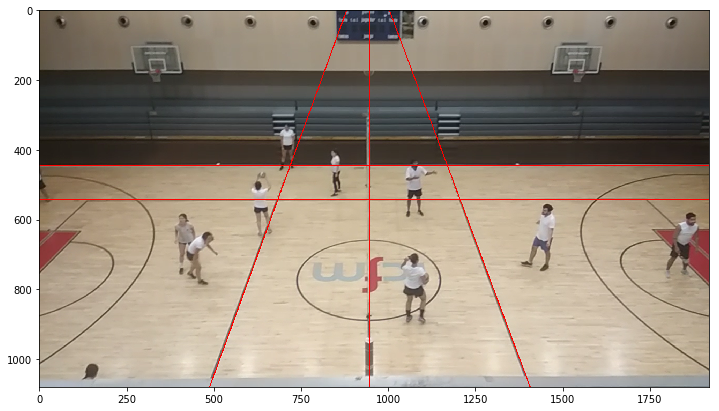

In [7]:
img=cv2.imread(image_path,1)
gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
edges = cv2.Canny(gray,50,150,apertureSize = 3)
lines = cv2.HoughLines(edges,0.5,np.pi/360,200)

l0 = find_nearest_line(lines, l0_aprox)
l1 = find_nearest_line(lines, l1_aprox)
l2 = find_nearest_line(lines, l2_aprox)
l3 = find_nearest_line(lines, l3_aprox)
l4 = find_nearest_line(lines, l4_aprox)

lines = [l0,l1,l2,l3,l4]
line_length = 20000

for line in lines:
    rho,theta=line[0]
    a = np.cos(theta)
    b = np.sin(theta)
    x0 = a*rho
    y0 = b*rho
    x1 = int(x0 + line_length*(-b))
    y1 = int(y0 + line_length*(a))
    x2 = int(x0 - line_length*(-b))
    y2 = int(y0 - line_length*(a))

    cv2.line(img,(x1,y1),(x2,y2),(0,0,255),2)
    
#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img))

### Encontrar puntos de intersección de las líneas

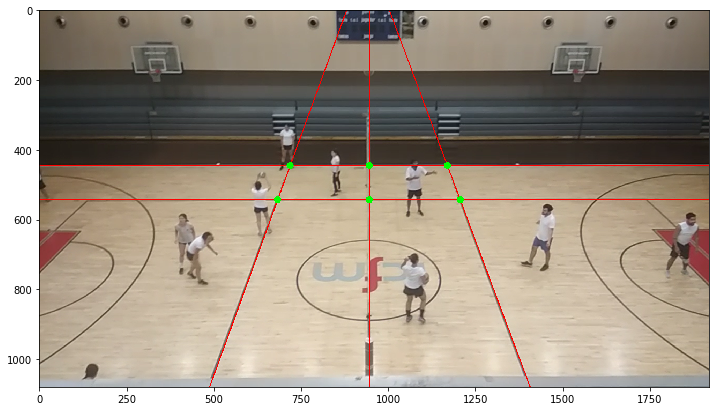

In [8]:
p2 = line_intersection(l1,l2)
p3 = line_intersection(l0,l2)
p4 = line_intersection(l1,l3)
p5 = line_intersection(l0,l3)
p6 = line_intersection(l1,l4)
p7 = line_intersection(l0,l4)

intersection_points = np.array([p2,p3,p4,p5,p6,p7])

for point in intersection_points:
    p_x, p_y = point
    cv2.circle(img, (p_x,p_y), 10, (0,255,0), -1)
    
#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img))

### Puntos en el dibujo de la cancha

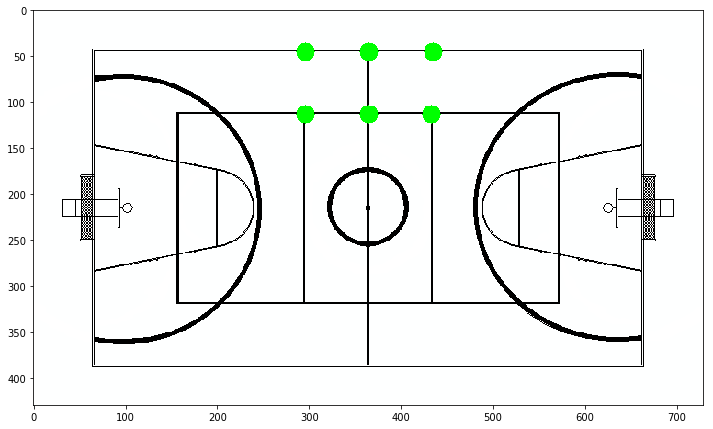

In [9]:
puntos_dibujo_cancha = np.array([[296,113],[296,45],[365,113],[365,45],[433,113],[435,45]])
for points in puntos_dibujo_cancha:
    p_x, p_y = points
    cv2.circle(img_dibujo, (p_x,p_y), 10, (0,255,0), -1)
    
#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img_dibujo))

### Encontrar homografía y realizar proyección

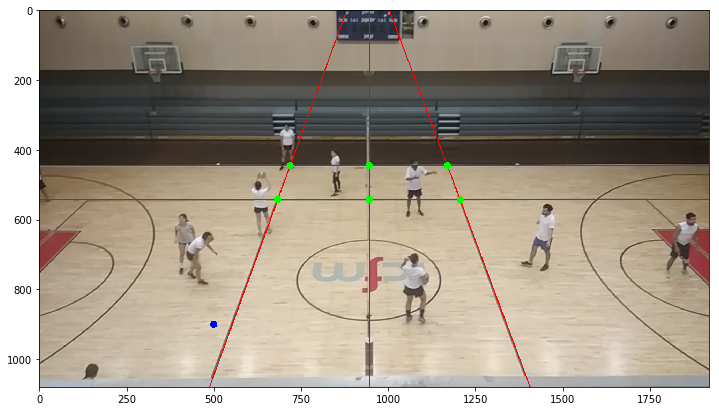

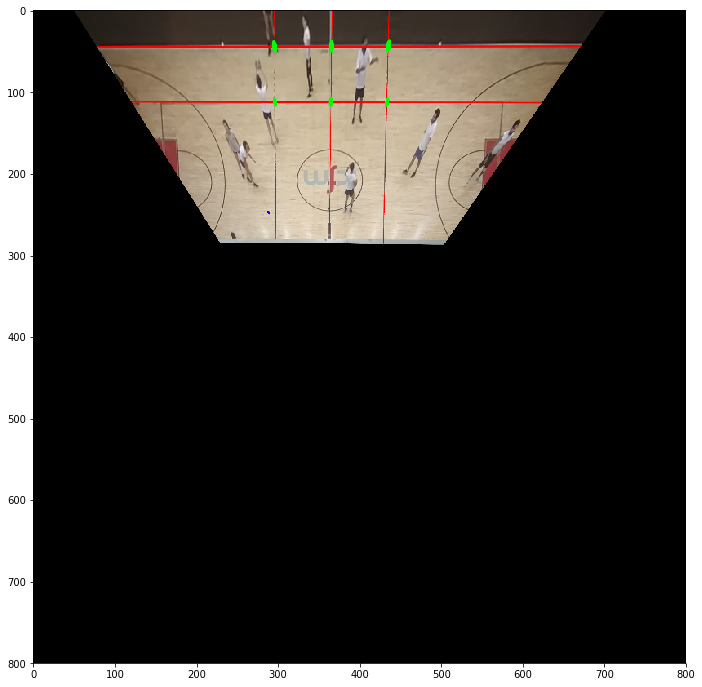

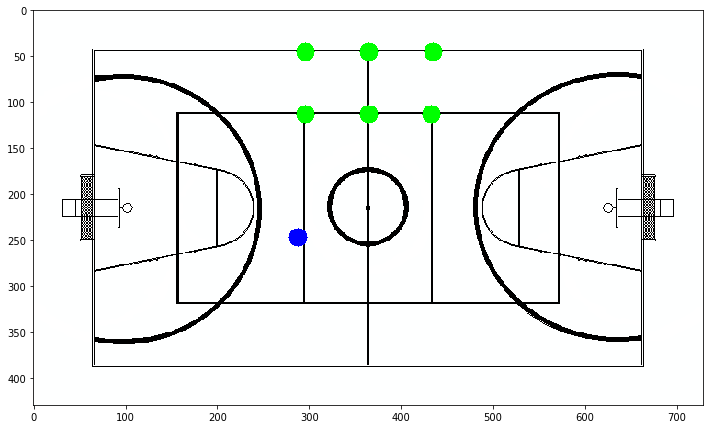

In [10]:
#Seleccionar un punto de la cancha en la imagen original
punto_cancha = np.array([500.0, 900.0])
cv2.circle(img, (int(punto_cancha[0]),int(punto_cancha[1])), 10, (255,0,0), -1)


#Encontrar homografia y transformar imagen
transformation_matrix, mask = cv2.findHomography(intersection_points, puntos_dibujo_cancha, method=cv2.RANSAC)
img_transformed = cv2.warpPerspective(img, transformation_matrix, (800,800))

#Proyectar punto seleccionado al dibujo
punto_proyectado = transform_point(punto_cancha, transformation_matrix)
cv2.circle(img_dibujo,(int(punto_proyectado[0]),int(punto_proyectado[1])), 10, (255,0,0), -1)

#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img))

#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img_transformed))

#Plot image
plt.figure(figsize=(12,12))
plt.imshow(bgr2rgb(img_dibujo))